In [1]:
# Note: The codes were originally created by Prof. Jack Baker in the MATLAB

from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
from fn_PSHA import fn_PSHA
from scipy.interpolate import interp1d
import json
%matplotlib inline

In [2]:
# IM parameters
x = np.logspace(np.log10(0.05), np.log10(2), 100) # IM values to consider 
x_example = 0.5 # example IM value for table
T = 1 
IM_label = 'Spectral Acceleration, SA(1s) [g]'

# general seismicity parameters
rup = {"Fault_Type":1, "Vs30":500, "R":10, "Ztor":0, "delta":90, "lambda0":0, "Z10":999, "Fhw":0, "FVS30":0, "region":1}

# plotting parameters
figureAxisLimits = [0.05, max(x), 0.99e-5, 1e-1]
figureXTickVals = [0.05, 0.1, 0.5, 1, 2]

In [3]:
# point source with G-R magnitudes

# From Table 3.5, \label{tab:grExample_mMax}, fixed rate of M>5
lambda_M3 = [0.05, 0.0315, 0.01983, 0.01247, 0.007819, 0.004887, 0.003037, 0.00187, 0.001133, 0.0006685, 0.0003753, 0.0001904, 7.36e-05, 0, 0]
lambda_M2 = [0.05, 0.03152, 0.01986, 0.0125, 0.007858, 0.004929, 0.00308, 0.001914, 0.001179, 0.0007143, 0.0004214, 0.0002366, 0.00012, 4.64e-05, 0]
lambda_M1 = [0.05, 0.03153, 0.01988, 0.01252, 0.007882, 0.004955, 0.003108, 0.001942, 0.001207, 0.0007432, 0.0004505, 0.0002657, 0.0001492,7.57e-05, 2.93e-05]
lambda_M = [lambda_M1, lambda_M2, lambda_M3]

M_vals = [5.1, 5.3, 5.5, 5.7, 5.9, 6.1, 6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.7, 7.9]
M_max = [8, 7.8, 7.6]
M_max_w = [0.3, 0.4, 0.3]

# elements = [lambda_M1, lambda_M2, lambda_M3]
# names = ["lambda_M1", "lambda_M2", "lambda_M3"]
# lambda_M = []
# i = 0
# for ele in elements:
#     ele = ele.replace('\t', ',')
#     lambda_M.append(ast.literal_eval(ele)) 
#     i += 1
# M_vals = M_vals.replace('\t', ',')    
# M_vals = ast.literal_eval(M_vals)


lambdaCases = [0.6, 1, 1.4]
lambda_w = [0.3, 0.4, 0.3]
            
GMM = [1, 2, 3] # 1=Atkinson (2015)
GMM_w = [0.3, 0.3, 0.4] # weights for these branches

# loop over logic tree branches
if T != 1:
    wt = []
    lambda_x = []
    idx = 0 # running index for the outputs
    for i in range(len(lambdaCases)):
        for j in range(len(M_max)):
            for k in range(len(GMM)): 
                idx += 1 # increment index
                rup["gmm"] = GMM[k] # assign the GMM index
                midvalue, _, _, _ = fn_PSHA(rup, M_vals, lambdaCases[i]*np.array(lambda_M[j]), T, x, x_example)
                lambda_x.append(midvalue) 
                wt.append(lambda_w[i] * M_max_w[j] * GMM_w[k]) 
    # Save outputs
    json_data = {'wt': wt, 'lambda_x': lambda_x}
    with open('hazardEpistemicData.json', 'w') as fp:
        json.dump(json_data, fp, sort_keys=True, indent=4)
else:
    with open('./hazardEpistemicData.json') as f:
        input_data = json.load(f)
    wt = input_data["wt"]
    lambda_x = input_data["lambda_x"]

In [4]:
# Compute mean and fractiles
fractile_targets = np.array([0.150001, 0.50001, 0.850001]) # Want to choose the larger nearest neighbor below
fractile_indices = [round(x) for x in (fractile_targets * len(lambda_x))] # TODO: this is not right for non-uniform weights, as it doesn't take weights into account
lambda_x = np.array(lambda_x)
wt = np.array(wt)
lambda_mean = []
lambda_fractiles = []

for k in range(len(x)):
    # mean hazard
    lambda_mean.append(np.sum(lambda_x[:,k] * wt))
    
    # fractiles of hazard
    lambdaSort = np.sort(lambda_x[:,k])
    dataIDX = np.argsort(lambda_x[:,k]) # order branches from lowest rate to highest
    weightCum = np.cumsum(wt[dataIDX]) # order weights appropriately, and cumulatively sum
    interpF = interp1d(weightCum, lambdaSort, kind='nearest')
    temp = interpF(fractile_targets) # nearest neighbor interpolation--take closest branch
    lambda_fractiles.append(temp)

lambda_fractiles = np.transpose(lambda_fractiles)


[Text(0, 0, '0.05'),
 Text(0, 0, '0.1'),
 Text(0, 0, '0.5'),
 Text(0, 0, '1'),
 Text(0, 0, '2')]

<Figure size 432x288 with 0 Axes>

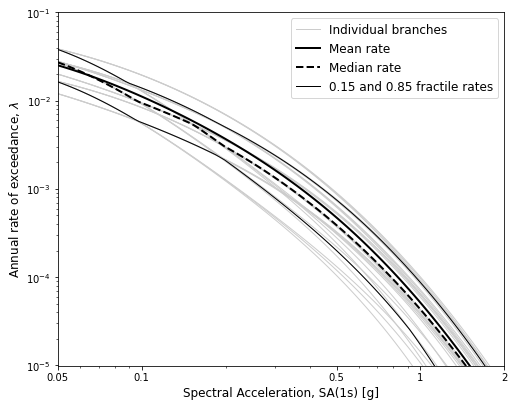

In [5]:
# Plot Fig 6.16
plt.figure(1)
fig, ax = plt.subplots(figsize=(8, 6.5))
ax.loglog(x, lambda_x[0], linestyle='-', color='0.8', linewidth=1, label='Individual branches')
for i in range(1, len(lambda_x)):
    ax.loglog(x, lambda_x[i], linestyle='-', color='0.8', linewidth=1)
ax.loglog(x, lambda_mean, '-k', linewidth=2, label='Mean rate')
ax.loglog(x, lambda_fractiles[1], '--k', linewidth=2, label='Median rate')
ax.loglog(x, lambda_fractiles[0], '-k', linewidth=1, label='0.15 and 0.85 fractile rates')
ax.loglog(x, lambda_fractiles[2],  '-k', linewidth=1)

ax.set_xlabel(IM_label, fontsize = 12)
ax.set_ylabel('Annual rate of exceedance, $\lambda$', fontsize = 12)
ax.set_ylim(figureAxisLimits[2], figureAxisLimits[3])
ax.set_xlim(figureAxisLimits[0], figureAxisLimits[1])
ax.legend(loc='upper right', fontsize=12)
ax.set_xticks(figureXTickVals)
ax.set_xticklabels(figureXTickVals)

<Figure size 432x288 with 0 Axes>

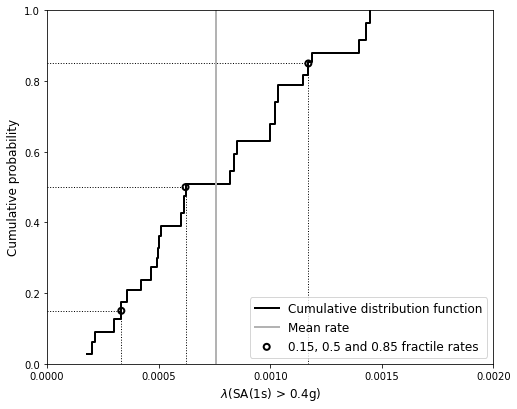

In [6]:
# Compute CDF
idxIM = 57  # index of IM level to consider
SaVal = x[idxIM]
data = lambda_x[:, idxIM]
dataSort = np.sort(data) # order from lowest rate to highest
dataIDX = np.argsort(data)
weightCum = np.cumsum(wt[dataIDX]) # order weights appropriately, and cumulatively sum

# Plot Fig 6.17
plt.figure(2)
fig, ax = plt.subplots(figsize=(8, 6.5))
ax.step(dataSort, weightCum, where='post', color='k', linewidth=2, label='Cumulative distribution function')
ax.scatter(lambda_fractiles[:,idxIM], fractile_targets, facecolors='none', edgecolor='k', linewidth=2, label='0.15, 0.5 and 0.85 fractile rates')
ax.plot([lambda_mean[idxIM],lambda_mean[idxIM]], [0,1], linestyle='-', linewidth=2, color=[0.7,0.7,0.7], label='Mean rate')
ax.hlines(fractile_targets, [0]*3, lambda_fractiles[:,idxIM], linestyle='dotted', linewidth=1)
ax.vlines(lambda_fractiles[:,idxIM], [0]*3, fractile_targets, linestyle='dotted', linewidth=1)

ax.set_xlabel('$\lambda$(SA(1s) > 0.4g)', fontsize = 12)
ax.set_ylabel('Cumulative probability', fontsize = 12)
ax.set_ylim(0, 1)
ax.set_xlim(0, 0.002)
ax.legend(loc='lower right', fontsize=12)
ax.set_xticks(np.array([0,0.5,1,1.5,2])/1e3)
